In [59]:
import csv
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors,cluster,model_selection
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
%matplotlib inline 

In [77]:
risk_data = []

with open("Risk_Data.csv", "rt") as csvfile:
    reader = csv.reader(csvfile, delimiter = ",")
    next(reader)
    for row in reader:
        for i in range(len(row)):
            try:
                row[i] = int(row[i])
            except:
                try:
                    row[i] = float(row[i])
                except:
                    pass
        risk_data.append(row)
        
print("num communes: " + str(len(risk_data)))

num communes: 140


In [78]:
#labeled and unlabeled (so labeled can be split for training/testing)
labeled1 = []
unlabeled1 = []

for i in risk_data:
    if i[-1] != '':
        labeled1.append(i)
    else:
        unlabeled1.append(i)
        
labeled = labeled1[2:]
unlabeled = unlabeled1[2:]

In [79]:
def test_classifier(clf, features, n_splits=3):
    """
    Test basic classifier using Stratified K-fold feature selection. The best train/test
    split is used to create the confusion matrix
    """
    Y = np.asarray(labeled)
    folds = list(StratifiedKFold(n_splits, shuffle = True).split(np.asarray(labeled)[:,:-1], Y[:,-1]))
    scores = cross_val_score(clf, features, Y[:,-1], scoring="accuracy", cv=folds)
    print(scores)
    best_fold_train, best_fold_test = folds[np.argmax(scores)]
    clf.fit(features[best_fold_train], Y[best_fold_train, -1])
    Y_predict = clf.predict(features[best_fold_test])
    cm = confusion_matrix(Y[best_fold_test,-1], Y_predict)
    plot_confusion_matrix(cm)
    print(classification_report(Y[best_fold_test,-1], Y_predict))
    new_predict = clf.predict(np.asarray(unlabeled)[:,:-1])
    print(new_predict)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    """
    Method to visualize confusion matrix
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[0.28571429 0.42857143 0.36842105]
             precision    recall  f1-score   support

        0.0       0.33      0.29      0.31         7
        1.0       0.50      0.56      0.53         9
        2.0       0.60      0.60      0.60         5

avg / total       0.47      0.48      0.47        21

[0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 2. 1. 1. 0. 1. 1.
 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0.]


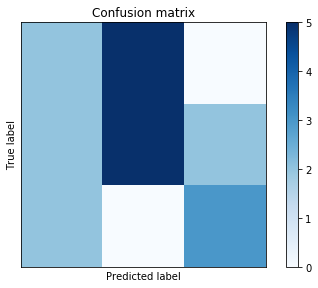

In [135]:
test_classifier(RandomForestClassifier(), np.asarray(labeled)[:,:-1])

[0.47619048 0.19047619 0.42105263]
             precision    recall  f1-score   support

        0.0       0.33      0.29      0.31         7
        1.0       0.50      0.67      0.57         9
        2.0       0.67      0.40      0.50         5

avg / total       0.48      0.48      0.47        21



TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'

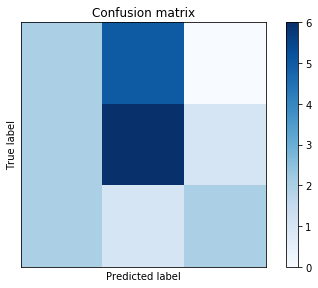

In [136]:
test_classifier(LogisticRegression(), np.asarray(labeled)[:,:-1])

[0.33333333 0.52380952 0.36842105]
             precision    recall  f1-score   support

        0.0       0.33      0.14      0.20         7
        1.0       0.46      0.67      0.55         9
        2.0       0.80      0.80      0.80         5

avg / total       0.50      0.52      0.49        21

[0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1.
 1. 0. 0.]


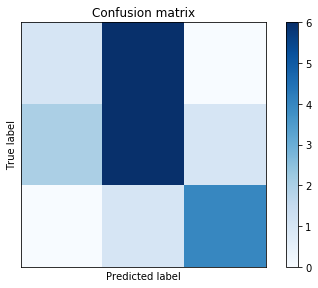

In [143]:
test_classifier(neighbors.KNeighborsClassifier(n_neighbors = 10), np.asarray(labeled)[:,:-1])

[0.42857143 0.52380952 0.21052632]
             precision    recall  f1-score   support

        0.0       0.37      1.00      0.54         7
        1.0       0.00      0.00      0.00         9
        2.0       0.00      0.00      0.00         5

avg / total       0.12      0.33      0.18        21

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


/Users/patriciaray/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


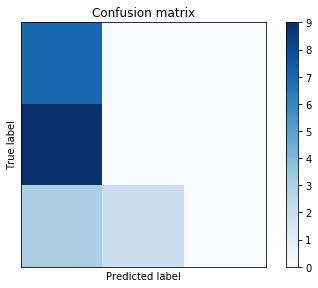

In [149]:
test_classifier(cluster.KMeans(n_clusters=3), np.asarray(labeled)[:,:-1])

[0.52380952 0.47619048 0.36842105]
             precision    recall  f1-score   support

        0.0       0.40      0.29      0.33         7
        1.0       0.50      0.44      0.47         9
        2.0       0.62      1.00      0.77         5

avg / total       0.50      0.52      0.50        21

[1. 0. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 2. 1. 2. 0. 2. 0. 1. 0. 0. 2. 1. 2. 0. 0. 1.
 0. 0. 1. 1. 0. 1. 0. 2. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 1.]


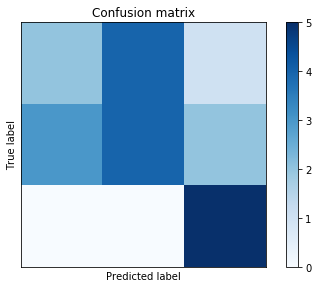

In [183]:
test_classifier(GradientBoostingClassifier(), np.asarray(labeled)[:,:-1])

[0.61904762 0.38095238 0.36842105]
             precision    recall  f1-score   support

        0.0       0.38      0.43      0.40         7
        1.0       0.62      0.56      0.59         9
        2.0       0.60      0.60      0.60         5

avg / total       0.54      0.52      0.53        21

[0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 2. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 1.]


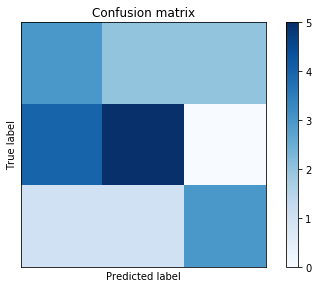

In [203]:
test_classifier(ExtraTreesClassifier(), np.asarray(labeled)[:,:-1])

[0.52380952 0.42857143 0.57894737]
             precision    recall  f1-score   support

        0.0       0.67      0.33      0.44         6
        1.0       0.56      0.62      0.59         8
        2.0       0.57      0.80      0.67         5

avg / total       0.59      0.58      0.56        19

[1. 2. 1. 0. 1. 2. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 2. 1. 2. 1. 0.
 1. 0. 1. 0. 0. 1. 1. 2. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 2. 1. 0. 1. 1. 0.
 0. 0. 1. 1. 1. 2. 0. 2. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 2.
 0. 1. 1.]


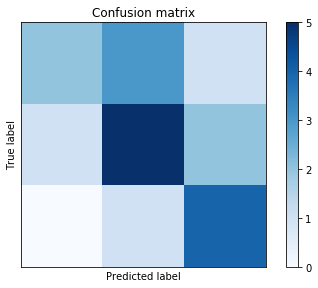

In [224]:
test_classifier(AdaBoostClassifier(), np.asarray(labeled)[:,:-1])

[0.52380952 0.47619048 0.52631579]
             precision    recall  f1-score   support

        0.0       0.33      0.50      0.40         6
        1.0       0.40      0.25      0.31         8
        2.0       0.60      0.60      0.60         5

avg / total       0.43      0.42      0.41        19

[0. 2. 0. 0. 0. 2. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 2. 1. 2. 0. 0.
 1. 0. 0. 1. 0. 1. 0. 2. 0. 2. 2. 0. 0. 0. 1. 1. 0. 1. 2. 0. 2. 0. 1. 1.
 0. 0. 0. 0. 0. 2. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 2.
 1. 0. 0.]


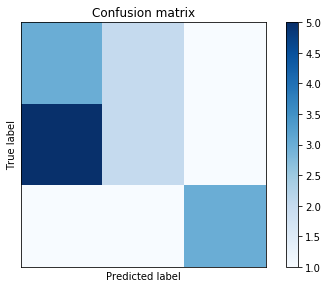

In [242]:
test_classifier(DecisionTreeClassifier(), np.asarray(labeled)[:,:-1])

# Ignore below this

In [3]:
#training and testing sets
test1 = unlabeled
test2 = []
train = []

while labeled != []:
    a = random.choice(labeled)
    a[-1] = math.ceil(float(a[-1]))
    test2.append(a)
    labeled.remove(a)
    try:
        b = random.choice(labeled)
        b[-1] = math.ceil(float(b[-1]))
        train.append(b)
        labeled.remove(b)
    except:jj
        pass
test = test1 + test2

In [4]:
X_train = []
Y_train = []

for i in train:
    X_train.append(i[1:-2])
    Y_train.append(i[-1])

X_test = []
Y_test = []

for j in test:
    X_test.append(j[1:-2])
    Y_test.append(j[-1])

In [5]:
lr = LogisticRegression()
lr.fit(np.asarray(X_train), np.asarray(Y_train))
output_lr = lr.predict(np.asarray(X_test))

count = 0
for i in range(len(Y_test)):
    if Y_test[i] == output_lr[i]:
        count = count + 1
print(count/30)

0.3


In [6]:
rf = RandomForestClassifier()
rf.fit(np.asarray(X_train), np.asarray(Y_train))
output_rf = rf.predict(np.asarray(X_test))

count = 0
for i in range(len(Y_test)):
    if Y_test[i] == output_rf[i]:
        count = count + 1
print(count/30)

0.4


In [7]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 10)
knn.fit(np.asarray(X_train), np.asarray(Y_train))
output_knn = knn.predict(np.asarray(X_test))

count = 0
for i in range(len(Y_test)):
    if Y_test[i] == output_knn[i]:
        count = count + 1
print(count/30)

0.5333333333333333


In [8]:
km = cluster.KMeans(n_clusters=4)
km.fit(np.asarray(X_train), np.asarray(Y_train))
output_km = km.predict(np.asarray(X_test))

count = 0
for i in range(len(Y_test)):
    if Y_test[i] == output_km[i]:
        count = count + 1
print(count/30)

0.36666666666666664


In [9]:
reg = LinearRegression()
reg.fit(np.asarray(X_train), np.asarray(Y_train))
output_reg = reg.predict(np.asarray(X_test))

count = 0
for i in range(len(Y_test)):
    if Y_test[i] == output_reg[i]:
        count = count + 1
print(count/30)

0.0


/Users/patriciaray/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


[21302, 376834, 249628, 37027, 150511, 116350, 31553, 34700, 29891, 10541, 23279, 86612, 274404, 57434, 36453, 199813, 266642, 203975, 48687, 54050, 25240, 63224, 172965, 39069, 45043, 55145, 395260, 56532, 144812, 36200]
[0, 3, 1, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 2, 1, 1, 2, 1, 0, 1, 2, 1, 0, 0, 2, 1, 2, 1, 0]


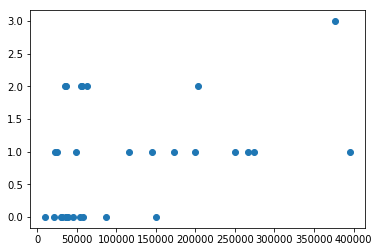

In [165]:
temp_x = []

for i in X_train:
    temp_x.append(i[0])
    
print(temp_x)
print(Y_train)
plt.scatter(temp_x,Y_train)
plt.show()